Дана статистика пользователей adult.csv.

Получите значения AUC для различных моделей и их параметров.

Решением будет ссылка на гитхаб с ноутбуком.

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score,average_precision_score,roc_auc_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score

In [2]:
adult = pd.read_csv('adult.csv')
adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [4]:
adult.income.value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [5]:
catgs = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
for each in catgs:
    print(each,'\n',adult[each].value_counts(),'\n\n')

workclass 
 Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64 


education 
 HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64 


marital-status 
 Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: marital-status, dtype: int64 


occupation 
 Prof-specialty       6172
Craft-repair 

# Подготовка данных

In [8]:
le = LabelEncoder()
le.fit(adult.income)
y = pd.Series(le.transform(adult.income))

In [35]:
catgs = ['workclass','education','occupation','native-country']
stat_sign = 5 
tree = DecisionTreeClassifier()
for catg in catgs:
    print('\n', catg,'\n')
    X = pd.get_dummies(adult[catg])
    tree.fit(X,y)
    for col,feat in zip(X.columns,tree.feature_importances_):
        if feat>0.05:
            print(f"{col} {feat*100:.2f}")


 workclass 

? 18.04
Federal-gov 5.13
Private 16.87
Self-emp-inc 59.09

 education 

Bachelors 24.30
Doctorate 15.73
Masters 28.25
Prof-school 22.36

 occupation 

Exec-managerial 36.32
Other-service 7.83
Prof-specialty 40.00

 native-country 

El-Salvador 5.59
India 5.13
Mexico 42.47


In [36]:
X = adult[['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']]
X.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [37]:
mms = MinMaxScaler()
X = pd.DataFrame(mms.fit_transform(X),columns=X.columns)

In [38]:
catgs = ['marital-status','occupation','relationship','race','gender']
X = pd.concat([X,pd.get_dummies(adult[catgs])],axis=1)

In [39]:
catgs = ['workclass','education','occupation','native-country']
keep_cols = ['workclass_?','workclass_Federal-gov','workclass_Private','workclass_Self-emp-inc',
             'education_Bachelors', 'education_Doctorate', 'education_Masters', 'education_Prof-school',
             'occupation_Exec-managerial','occupation_Other-service','occupation_Prof-specialty',
             'native-country_El-Salvador','native-country_India','native-country_Mexico']
X = pd.concat([X,pd.get_dummies(adult[catgs])[keep_cols]],axis=1)
X.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,...,education_Bachelors,education_Doctorate,education_Masters,education_Prof-school,occupation_Exec-managerial,occupation_Other-service,occupation_Prof-specialty,native-country_El-Salvador,native-country_India,native-country_Mexico
0,0.109589,0.145129,0.400000,0.000000,0.0,0.397959,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.287671,0.052451,0.533333,0.000000,0.0,0.500000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0.150685,0.219649,0.733333,0.000000,0.0,0.397959,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.369863,0.100153,0.600000,0.076881,0.0,0.397959,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.013699,0.061708,0.600000,0.000000,0.0,0.295918,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Выбор моделей

# Линейная

In [51]:
model = LogisticRegression()
model.fit(X_train, Y_train)

/Users/Belotelov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
predictions = model.predict_proba(X_test)

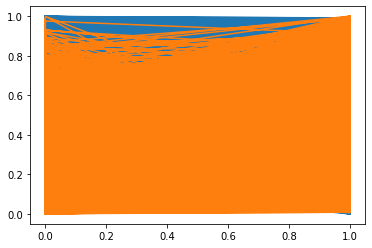

In [45]:
plt.plot(y_test, predictions)
plt.show()

In [53]:
model.score(X_test, Y_test)

0.8488364157510407

In [54]:
roc_auc_score( Y_test, predictions[:, 1] )

0.9017629598107998

In [55]:
fpr, tpr, thres = roc_curve( Y_test, predictions[:, 1] )

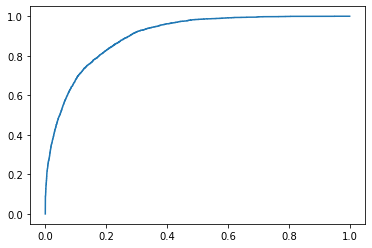

In [61]:
plt.plot( fpr, tpr )
plt.show()

In [59]:
auc( fpr, tpr )

0.9017629598107998

# Деревья решений

In [63]:
model2 = DecisionTreeClassifier()
model2.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [68]:
model2.score(X_test, Y_test)

0.8184672080802566

In [69]:
predictions2 = model2.predict_proba(X_test)

In [70]:
roc_auc_score( Y_test, predictions2[:, 1] )

0.7552916125054182

In [72]:
fpr, tpr, thres = roc_curve( Y_test, predictions2[:, 1] )

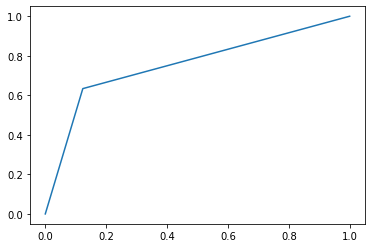

In [73]:
plt.plot( fpr, tpr )
plt.show()

In [74]:
auc( fpr, tpr )

0.7552916125054182

# Случайный лес

In [79]:
model_3 = RandomForestClassifier()
model_3.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [80]:
model_3.score(X_test, Y_test)

0.8539548215382515

In [81]:
predictions3 = model_3.predict_proba(X_test)

In [83]:
roc_auc_score( Y_test, predictions3[:, 1] )

0.9022412859031925

In [85]:
fpr, tpr, thres = roc_curve( Y_test, predictions3[:, 1] )

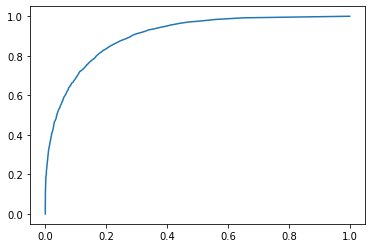

In [86]:
plt.plot( fpr, tpr )
plt.show()

In [87]:
auc( fpr, tpr )

0.9022412859031925

# Вывод: Наилучший результат по показателю AUC показала модель Случайный лес